In [1]:
import numpy as np
from matplotlib import pyplot as plt
import hpmoc as hpm
from hpmoc.healpy import healpy as hp
from hpmoc import PartialUniqSkymap
from hpmoc import utils as ut

u = np.concatenate([ut.nest2uniq(np.arange(2), 1), ut.nest2uniq(np.arange(8, 17), 2)])
x = np.full_like(u, 4)
m = np.array([1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8])
assert len(u) == len(m)

In [68]:
print(u)

[ 4  5 24 25 26 27 28 29 30 31 32]


In [4]:
ut.uniq2order(u)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [8]:
z = np.arange(ut.uniq2order(u[-1])+1, -1, -1)
ut.nest2uniq(np.zeros_like(z), hp.order2nside(z))

array([64, 16,  4])

In [25]:
z

array([2, 1, 0])

In [63]:
from operator import eq

def uniq_minimize(u, *x, test=eq, combine=lambda x, i: x[i]):
    isort = np.argsort(u)
    u = u[isort]
    x = [*x]
    us = []
    xs = [[] for _ in x]
    orders = np.arange(ut.uniq2order(u[-1])+1, -1, -1)
    bounds = np.searchsorted(u, ut.nest2uniq(np.zeros_like(orders),
                                             hp.order2nside(orders)))
    for xx in x:
        if len(xx) != len(u):
            raise ValueError("Indices and values must have same length.")
        xx = xx[isort]
    for i in range(len(bounds)-2):
        last, first = bounds[i:i+2]
        if last - first < 4:
            continue
        uu = u[first:last-3].copy()
        # find 0th pixels from matching quartets
        m = np.zeros((last-first,), dtype=bool)
        m[:-3] = uu % 4 == 0
        for j in range(3):
            uu += 1
            m[:-3] &= uu == u[first+1+j:last-2+j]
            for xx in x:
                m[:-3] &= test(xx[first:last-3], xx[first+1+j:last-2+j])
        # now find skipped indices
        s = m.copy()
        # do not mutate and compare simultaneously
        s[1:-2] = s[1:-2] | s[:-3]
        s[2:] = s[2:] | s[:-2]
        np.logical_not(s, out=s)
        # store the skipped indices for later concatenation
        us.append(u[first:last][s])
        for xxs, xx in zip(xs, x):
            xxs.append(xx[first:last][s])
        # combine pixels and put into existing buf adjacent next lowest order
        combined = u[first:last][m] // 4
        nc = len(combined)
        u[first:first+nc] = combined
        del combined
        for xx in x:
            xx[first:first+nc] = combine(xx[first:last], m)
        assert 4 * nc + len(us[-1]) == last - first
        # absorb combined pixels by modifying the next lowest order's bounds
        bounds[i+1] += nc
        # now re-sort the next lowest order
        next_last, next_first = bounds[i+1:i+3]
        isort = u[next_first:next_last].argsort()
        u[next_first:next_last] = u[next_first:next_last][isort]
        for xx in x:
            xx[next_first:next_last] = xx[next_first:next_last][isort]
    #breakpoint()
    return [np.concatenate([y[:bounds[-2]], *ys[::-1]])
            for y, ys in zip([u, *x], [us, *xs])]

In [69]:
print(uniq_minimize(u)[0])

[ 4  5  6  7 32]


In [72]:
print(uniq_minimize(u, x)[1]//4)

[1 1 1 1 1]


In [66]:
u

array([ 4,  5, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [73]:
um, xm = uniq_minimize(u, np.array([1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8]))

In [75]:
print(xm)

[1 2 3 4 5 6 7 8]


In [2]:
m = PartialUniqSkymap.read("../tests/data/S191216ap.fits.gz", strategy="ligo")

In [3]:
mo = PartialUniqSkymap.read("../tests/data/S191216ap.multiorder.fits", strategy="ligo")

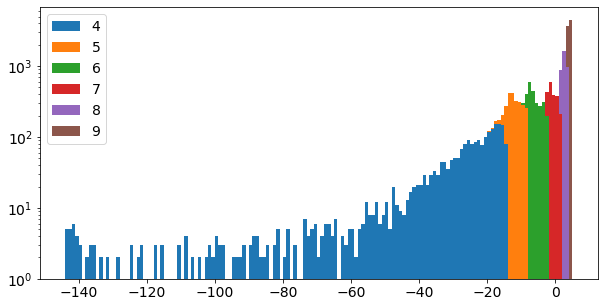

In [126]:
fig = plt.figure(figsize=(10, 5))
o = mo.o⃗()
lmo = np.log2(mo.s⃗.value)
os = [*range(o.min(), o.max()+1)]
plt.hist([lmo[o==oo] for oo in os],
         bins=[*range(int(np.floor(lmo.min())),
                      int(np.ceil(lmo.max())+1))],
         label=os, log=True, stacked=True)
plt.legend()

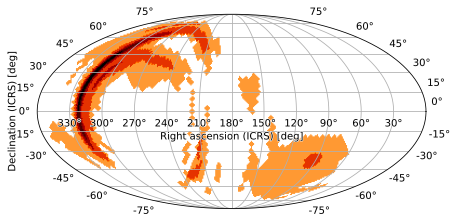

In [4]:
mo.o⃗(as_skymap=True).plot()

In [124]:
plt.hist?

In [94]:
u, s = uniq_minimize(m.u⃗, m.s⃗)

In [97]:
(mo.u⃗ == u).all()

True

In [99]:
mm = mo.s⃗ != s

In [105]:
((mo.s⃗-s)/s)[mm].max() < 1e-15

True

In [16]:
np.searchsorted?

In [15]:
np.arange(ut.uniq2nside(u[-1]), ut.uniq2nside(u[0])-1, -1)

array([2, 1])

In [37]:
ut.uniq2order(u)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])